# Dynamic Time Warping

Dynamic time warping (DWT) is a dynamic programming algorithm to find the **optimal** alignment between to time-dependent sequences.

In this notebook we will explore how this algorithm works.

In [1]:
import numpy as np
from helper import generate_example_sequences
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
%matplotlib inline

(0.0, 20.0)

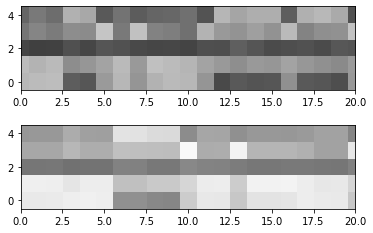

In [2]:
X, Y, gr_path = generate_example_sequences(noise_scale=0.1)
# Dataset

vmax = max(max(abs(X.max()), abs(X.min())), max(abs(Y.max()), abs(Y.min())))
fig, axes = plt.subplots(2, sharex=False)
axes[0].imshow(X.T, cmap='gray', origin='lower', aspect='equal', interpolation=None, vmax=vmax, vmin=-vmax)
axes[1].imshow(Y.T, cmap='gray', origin='lower', aspect='equal', interpolation=None, vmax=vmax, vmin=-vmax)
axes[0].set_xlim((0, 20))
axes[1].set_xlim((0, 20))

In [13]:
def pairwise_distance_matrix(X, Y, metric='euclidean'):
    """
    Compute pairwise distance matrix of two sequences
    
    Parameters
    ----------
    X : np.ndarray
        A 2D array with size (n_observations, n_features)
    Y : np.ndarray
        A 2D array with size (m_observations, n_features)
    metric: str
        A string defining a metric (see possibilities 
        in scipy.spatial.distance.cdist)

    Returns
    -------
    D : np.ndarray
        Pairwise cost matrix
    """
    if X.ndim == 1:
        X, Y = np.atleast_2d(X, Y)
        X = X.T
        Y = Y.T
    C = cdist(X, Y, metric=metric)
    return C

print(C.shape)

(100, 203)


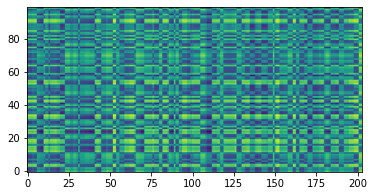

In [16]:
# Visualize cost matrix
# X = np.array([1, 3, 3, 8])
# Y = np.array([2, 0, 0, 8, 7])

C = pairwise_distance_matrix(X, Y)

plt.imshow(C, origin='lower', aspect='equal')

In [ ]:
def accumulated_cost_matrix(C):
    """
    Dynamic time warping cost matrix from a pairwise distance matrix

    Parameters
    ----------
    D : double array
        Pairwise distance matrix (computed e.g., with `cdist`).

    Returns
    -------
    D : np.ndarray
        Accumulated cost matrix
    """
    N = C.shape[0]
    M = C.shape[1]
    D = np.ones((N + 1, M + 1),
                   dtype=float) * np.inf

    # Compute the distance iteratively
    D[0, 0] = 0
    for i in range(1, N + 1):
        for j in range(1, M + 1):

            c = C[i - 1, j - 1]
            insertion = D[i - 1, j]
            deletion = D[i, j - 1]
            match = D[i - 1, j - 1]
            D[i, j] = c + min((insertion, deletion, match))
    return D[1:, 1:]
print(C.shape)
D = accumulated_cost_matrix(C) 
print(D.shape)